**Dataset**: Beijing PM2.5 Data Set

**Model**: LSTM

**Type**: Multivariate 

In [1]:
# import the libraries
from datetime import datetime

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

# load data, parse data-time columns as single column and set it index
dataset = read_csv('../../../datasets/pollution_raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.head(5)

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
# drop "No" column
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

# name index column as "date"
dataset.index.name = 'date'
dataset.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
dataset.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
# save to file
dataset.to_csv('pollution_clean.csv')

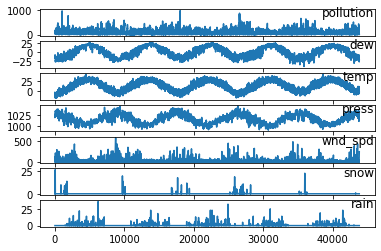

In [6]:
# load dataset which is saved recently
dataset = read_csv('pollution_clean.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot, 4th column is categorical one(wnd_dir)
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    # for 5 years 
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

Time series forecasting problems must be re-framed as **supervised learning problems**. From a sequence to pairs of input and output sequences.[https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/]

In [7]:
# convert time series(dataset) to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [8]:
values = dataset.values
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [9]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

In [10]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [11]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [12]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


### Fit the model 

In [13]:
# split the dataset into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [14]:
# splits the train and test sets into input and output variables
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [15]:
# the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


### Define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer

In [16]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 7s - loss: 0.0577 - val_loss: 0.0541 - 7s/epoch - 59ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0387 - val_loss: 0.0522 - 1s/epoch - 8ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0233 - val_loss: 0.0441 - 988ms/epoch - 8ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0178 - val_loss: 0.0361 - 1s/epoch - 8ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0159 - val_loss: 0.0235 - 1s/epoch - 8ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0150 - val_loss: 0.0174 - 1s/epoch - 8ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0160 - 1s/epoch - 9ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0155 - 972ms/epoch - 8ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0148 - 960ms/epoch - 8ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0151 - 1s/epoch - 9ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0140 - 1s/epoch - 8ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0140 - 1s/epoch - 9ms/step
Epoch 13/50
122/122 - 1s - 

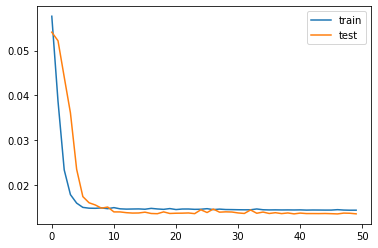

In [17]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Evaluate Model
forecast for the entire **test** dataset

In [18]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.598


### Train On Multiple Lag Timesteps

[to be continued]

- One-step time series forecasts, only one time step is to be predicted(Eg; observed data is from day 1 to day 7, then will predict for day 8)
- Multiple-step time series forecasts ( will predict/forecast for the next two days like day 8 and day 9 ...)

Src: https://machinelearningmastery.com/multi-step-time-series-forecasting/

### Develop Machine Learning models for Multi-step Time Series Forecasting

Multivariate \
Multi-Step

In [19]:
from numpy import unique
from numpy import array
from numpy import savetxt
from numpy import nan

In [20]:
# load dataset
df = read_csv('../../../datasets/AirQualityPrediction_training.csv', header=0)
df.head(5)

,rowID,chunkID,position_within_chunk,month_most_common,weekday,hour,Solar.radiation_64,WindDirection..Resultant_1,WindDirection..Resultant_1018,WindSpeed..Resultant_1,...,target_4_6006,target_4_8003,target_5_6006,target_7_57,target_8_57,target_8_4002,target_8_6004,target_8_8003,target_9_4002,target_9_8003
0,1,1,1,10,Saturday,21,0.01,117.0,187.0,0.3,...,1.748424,NaN,NaN,5.130631,1.341606,2.138792,3.013752,NaN,5.679280,NaN
1,2,1,2,10,Saturday,22,0.01,231.0,202.0,0.5,...,2.144120,NaN,NaN,5.130631,1.195779,2.722099,3.888712,NaN,7.426751,NaN
2,3,1,3,10,Saturday,23,0.01,247.0,227.0,0.5,...,1.932469,NaN,NaN,5.136395,1.409658,3.110970,3.888712,NaN,7.683732,NaN
3,4,1,4,10,Sunday,0,0.01,219.0,218.0,0.2,...,2.088907,NaN,NaN,5.217102,1.477711,2.041574,3.208188,NaN,4.831243,NaN
4,5,1,5,10,Sunday,1,0.01,2.0,216.0,0.2,...,2.604232,NaN,NaN,5.217102,1.458267,2.138792,3.499841,NaN,4.625658,NaN


In [21]:
df.shape

(37821, 95)

In [22]:
# split the dataset by 'chunkID', return a dict of id to rows
# each chunk is eight contiguous days of observations and target variables.
def to_chunks(values, chunk_ix=1):
    chunks = dict()
    # get the unique chunk ids
    chunk_ids = unique(values[:, chunk_ix])
    # group rows by chunk id
    for chunk_id in chunk_ids:
        selection = values[:, chunk_ix] == chunk_id
        chunks[chunk_id] = values[selection, :]
    return chunks

In [23]:
# group data by chunks
values = df.values
chunks = to_chunks(values)
print('Total Chunks in the dataset: %d' % len(chunks))

Total Chunks in the dataset: 208


In [24]:
# split each chunk into train/test sets
def split_train_test(chunks, row_in_chunk_ix=2):
    train, test = list(), list()
    # first 5 days of hourly observations for train
    cut_point = 5 * 24
    # enumerate chunks
    for k,rows in chunks.items():
        # split chunk rows by 'position_within_chunk'
        train_rows = rows[rows[:,row_in_chunk_ix] <= cut_point, :]
        test_rows = rows[rows[:,row_in_chunk_ix] > cut_point, :]
        if len(train_rows) == 0 or len(test_rows) == 0:
            print('>dropping chunk=%d: train=%s, test=%s' % (k, train_rows.shape, test_rows.shape))
            continue
        # store with chunk id, position in chunk, hour and all targets
        indices = [1,2,5] + [x for x in range(56,train_rows.shape[1])]
        train.append(train_rows[:, indices])
        test.append(test_rows[:, indices])
    return train, test

In [25]:
# return a list of relative forecast lead times(required), original is three days, 24x3 = 72 hrs
def get_lead_times():
    return [1, 2 ,3, 4, 5, 10, 17, 24, 48, 72]

In [26]:
# convert the rows in a test chunk to forecasts
def to_forecasts(test_chunks, row_in_chunk_ix=1):
    # get lead times
    lead_times = get_lead_times()
    # first 5 days of hourly observations for train
    cut_point = 5 * 24
    forecasts = list()
    # enumerate each chunk
    for rows in test_chunks:
        chunk_id = rows[0, 0]
        # enumerate each lead time
        for tau in lead_times:
            # determine the row in chunk we want for the lead time
            offset = cut_point + tau
            # retrieve data for the lead time using row number in chunk
            row_for_tau = rows[rows[:,row_in_chunk_ix]==offset, :]
            # check if we have data
            if len(row_for_tau) == 0:
                # create a mock row [chunk, position, hour] + [nan...]
                row = [chunk_id, offset, nan] + [nan for _ in range(39)]
                forecasts.append(row)
            else:
                # store the forecast row
                forecasts.append(row_for_tau[0])
    return array(forecasts)

In [27]:
# split into train/test
train, test = split_train_test(chunks)
# flatten training chunks to rows
train_rows = array([row for rows in train for row in rows])
print('Train Rows: %s' % str(train_rows.shape))

>dropping chunk=69: train=(0, 95), test=(28, 95)
Train Rows: (23514, 42)


In [28]:
# reduce test to forecast lead times only
test_rows = to_forecasts(test)
print('Test Rows: %s' % str(test_rows.shape))

Test Rows: (2070, 42)


In [29]:
# save datasets
savetxt('naive_train.csv', train_rows, delimiter=',')
savetxt('naive_test.csv', test_rows, delimiter=',')

### Evaluation

In [30]:
# convert the test dataset in chunks to [chunk][variable][time] format
def prepare_test_forecasts(test_chunks):
    predictions = list()
    # enumerate chunks to forecast
    for rows in test_chunks:
        # enumerate targets for chunk
        chunk_predictions = list()
        for j in range(3, rows.shape[1]):
            yhat = rows[:, j]
            chunk_predictions.append(yhat)
        chunk_predictions = array(chunk_predictions)
        predictions.append(chunk_predictions)
    return array(predictions)

In [31]:
# calculate the error between an actual and predicted value
def calculate_error(actual, predicted):
    # give the full actual value if predicted is nan
    if isnan(predicted):
        return abs(actual)
    # calculate abs difference
    return abs(actual - predicted)

In [32]:
def evaluate_forecasts(predictions, testset):
    lead_times = get_lead_times()
    total_mae, times_mae = 0.0, [0.0 for _ in range(len(lead_times))]
    total_c, times_c = 0, [0 for _ in range(len(lead_times))]
    # enumerate test chunks
    for i in range(len(test_chunks)):
        # convert to forecasts
        actual = testset[i]
        predicted = predictions[i]
        # enumerate target variables
        for j in range(predicted.shape[0]):
            # enumerate lead times
            for k in range(len(lead_times)):
                # skip if actual in nan
                if isnan(actual[j, k]):
                    continue
                # calculate error
                error = calculate_error(actual[j, k], predicted[j, k])
                # update statistics
                total_mae += error
                times_mae[k] += error
                total_c += 1
                times_c[k] += 1
    # normalize summed absolute errors
    total_mae /= total_c
    times_mae = [times_mae[i]/times_c[i] for i in range(len(times_mae))]
    return total_mae, times_mae

In [33]:
# summarize scores
def summarize_error(name, total_mae, times_mae):
    # print summary
    lead_times = get_lead_times()
    formatted = ['+%d %.3f' % (lead_times[i], times_mae[i]) for i in range(len(lead_times))]
    s_scores = ', '.join(formatted)
    print('%s: [%.3f MAE] %s' % (name, total_mae, s_scores))
    # plot summary
    pyplot.plot([str(x) for x in lead_times], times_mae, marker='.')
    pyplot.show()

[to be continued]

In [34]:
chunk_ids = unique(values[:, 1])
chunk_ids

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204,

Src: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/